
# Setup

In [1]:
! git clone https://github.com/AmarCodes-22/Skribbl-bot.git

Cloning into 'Skribbl-bot'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 84 (delta 29), reused 70 (delta 15), pack-reused 0
Unpacking objects: 100% (84/84), done.


In [2]:
import sys
sys.path.append('/content/Skribbl-bot')

In [3]:
# ! pip install -r /content/Skribbl-bot/requirements.txt
! pip install cairocffi

     |████████████████████████████████| 88 kB 4.0 MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.3.0-py3-none-any.whl size=89668 sha256=0cae470f6a26c4c8de981f57c96518ffe6dec744be3ebe87af029c3c1b922067
  Stored in directory: /root/.cache/pip/wheels/4e/ca/e1/5c8a9692a27f639a07c949044bec943f26c81cd53d3805319f
Successfully built cairocffi


# Generate cifar like dataset

In [4]:
from src.data.quickdraw_version import QuickdrawVersion

In [5]:
quickdraw_version = QuickdrawVersion(
    '/content/Skribbl-bot/resources/cifar-10.txt',
    '/content/cifar-like-quickdraw',
    num_images_per_class=100
)

Creating directory /content/cifar-like-quickdraw
Creating directory /content/cifar-like-quickdraw/binary
Creating directory /content/cifar-like-quickdraw/images


In [6]:
quickdraw_version.create_version_in_directory()

	 from bucket quickdraw_dataset
	 to /content/cifar-like-quickdraw/binary/airplane.bin
	 from bucket quickdraw_dataset
	 to /content/cifar-like-quickdraw/binary/car.bin
	 from bucket quickdraw_dataset
	 to /content/cifar-like-quickdraw/binary/bird.bin
	 from bucket quickdraw_dataset
	 to /content/cifar-like-quickdraw/binary/cat.bin
	 from bucket quickdraw_dataset
	 to /content/cifar-like-quickdraw/binary/bear.bin
	 from bucket quickdraw_dataset
	 to /content/cifar-like-quickdraw/binary/dog.bin
	 from bucket quickdraw_dataset
	 to /content/cifar-like-quickdraw/binary/frog.bin
	 from bucket quickdraw_dataset
	 to /content/cifar-like-quickdraw/binary/horse.bin
	 from bucket quickdraw_dataset
	 to /content/cifar-like-quickdraw/binary/cruise ship.bin
	 from bucket quickdraw_dataset
	 to /content/cifar-like-quickdraw/binary/truck.bin
Creating directory /content/cifar-like-quickdraw/images/cruise ship
Loading images for class cruise ship
Creating directory /content/cifar-like-quickdraw/images

In [7]:
quickdraw_version.split_train_test(test_ratio=0.1)

Creating directory /content/cifar-like-quickdraw/images/train
Creating directory /content/cifar-like-quickdraw/images/test
Creating directory /content/cifar-like-quickdraw/images/train/truck
Creating directory /content/cifar-like-quickdraw/images/test/truck
Creating directory /content/cifar-like-quickdraw/images/train/car
Creating directory /content/cifar-like-quickdraw/images/test/car
Creating directory /content/cifar-like-quickdraw/images/train/airplane
Creating directory /content/cifar-like-quickdraw/images/test/airplane
Creating directory /content/cifar-like-quickdraw/images/train/cruise ship
Creating directory /content/cifar-like-quickdraw/images/test/cruise ship
Creating directory /content/cifar-like-quickdraw/images/train/frog
Creating directory /content/cifar-like-quickdraw/images/test/frog
Creating directory /content/cifar-like-quickdraw/images/train/horse
Creating directory /content/cifar-like-quickdraw/images/test/horse
Creating directory /content/cifar-like-quickdraw/images

# Making Dataloaders

In [ ]:
# follow along https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [16]:
import copy
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '/content/cifar-like-quickdraw/images'

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) 
    for x in ['train', 'test']}

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x],
                                   batch_size=4,
                                   shuffle=True,
                                   num_workers=2)
    for x in ['train', 'test']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

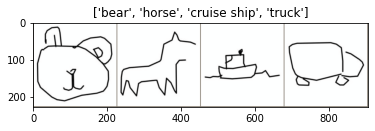

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
inputs, classes = next(iter(dataloaders['train']))
inputs.shape, classes.shape

(torch.Size([4, 3, 224, 224]), torch.Size([4]))

# Training the model

In [20]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                # optimizer.step()
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [13]:

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [22]:
model_ft = models.resnet18(pretrained=True)
num_features = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_features, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [23]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler)

Epoch 0/24
----------
train Loss: 1.6966 Acc: 0.4167

test Loss: 1.0260 Acc: 0.6400

Epoch 1/24
----------
train Loss: 1.0132 Acc: 0.6800

test Loss: 0.8320 Acc: 0.7100

Epoch 2/24
----------
train Loss: 0.8432 Acc: 0.7033

test Loss: 0.7814 Acc: 0.7200

Epoch 3/24
----------
train Loss: 0.6368 Acc: 0.7800

test Loss: 0.7676 Acc: 0.7100

Epoch 4/24
----------
train Loss: 0.5295 Acc: 0.8356

test Loss: 0.8866 Acc: 0.7400

Epoch 5/24
----------
train Loss: 0.3961 Acc: 0.8800

test Loss: 0.8007 Acc: 0.7500

Epoch 6/24
----------
train Loss: 0.3704 Acc: 0.8856

test Loss: 0.8802 Acc: 0.7200

Epoch 7/24
----------
train Loss: 0.2849 Acc: 0.9156

test Loss: 0.8489 Acc: 0.7200

Epoch 8/24
----------
train Loss: 0.2132 Acc: 0.9456

test Loss: 0.8028 Acc: 0.7400

Epoch 9/24
----------
train Loss: 0.2168 Acc: 0.9522

test Loss: 0.8219 Acc: 0.7500

Epoch 10/24
----------
train Loss: 0.2017 Acc: 0.9456

test Loss: 0.8000 Acc: 0.7300

Epoch 11/24
----------
train Loss: 0.1977 Acc: 0.9556

test Loss

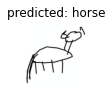

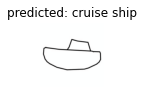

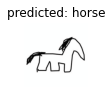

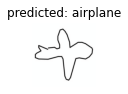

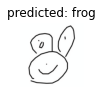

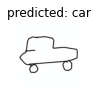

In [28]:
visualize_model(model_ft)

In [30]:
torch.save(model_ft.state_dict(), '/content/resnet-finetuned.pt')